# Fastener Image Classification using Convolutional Neural Network
This project aims to design, build, train and tune a CNN to classify a set of images belonging to the different classes of mechanical fasteners; namely nuts, bolts, washers and locating pins.  
The data used here is already preprocessed and stored as a `images.npy` file along with the corresponding labels in `labels.npy` using the `data_storage.py` script in the repo. The original images were obtained from the GitHub repo titled ["Mech-parts-classification-seq-model"](https://github.com/Promech2020/Mech-parts-classification-seq-model) of [Pro-Mech Minds](https://www.promechminds.com/). 

**NOTE:**  
All references to external resources are present as links in the respective words or phrases instead of a traditional reference section. All code blocks that need to be run only if Colab is used start with the comment `#GConly`.


In [1]:
%tensorflow_version 2.x
%matplotlib inline

The above magic commands are used to ensure that Tensorflow 2.0 is used and any matplotlib objects when displayed are within the notebook. Now, we import all the standard libraries that we require.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Since this is done in Colab, we run the following commands to ensure that a GPU is allocated and is being used for our work

In [3]:
#GConly
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Loading in our Data
View README before doing the following. The data is stored in my Google Drive, so we mount it before accessing the files.

In [4]:
#GConly
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Now, we can load in our image data and labels as numpy arrays using the *numpy.load()* function.

In [5]:
X = np.load("/content/gdrive/My Drive/fastener_classification/images.npy", allow_pickle=True)
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(7616, 224, 224)


In [6]:
y = np.load("/content/gdrive/My Drive/fastener_classification/labels.npy", allow_pickle=True)
print(type(y))
print(y.shape)

<class 'numpy.ndarray'>
(7616,)


We have successfully loaded in our dataset which has 7616 observations, each an array of size 224 by 224 with all elements lying between 0 and 1 based on the pixel values (called features). Let us check our data using a simple script shown below that takes any index value and displays the correspnoding image as well as its label.

Enter any image index: 5000
Label number: 3
Fastener type: nut


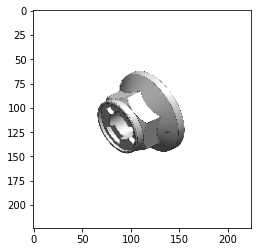

In [7]:
label_list = ["bolt", "locating pin", "nut", "washer"]

index = int(input('Enter any image index: '))
print("Label number:", y[index])
print("Fastener type:", label_list[y[index]])
plt.imshow(X[index], cmap='gray')

## Undertanding our Data
Now that we have successfully loaded in our data and had an initial look at its characteristics, let us present the fine details of structure and design of the original iamges as well as the processed array data.  
The detailes about the original images are presented in a [Medium article](https://towardsdatascience.com/artificial-intelligence-in-mechanical-engineering-a9dd94adc492) written by [Sunny K. Tuladhar](https://medium.com/@k.sunman91),
Senior Mechanical Engineer/Team Leader at Pro-Mech Minds and Engineering Services. In it, the team at Pro-Mech Mind found 238 3D models of the 4 parts being discussed. Then, a program using FreeCAD API was run on these images that automatically took 8 isometric screenshots of 224 x 224 pixels of each part. This can be considered as data augmentation, even though it does not strictly follow the standard definition. In total, 4_classes x 238_images x 8_augments gives us 7616 images, each of size 224x224, with 1904 images per class. All of the images were saved in `.png` format and separated into folders based on class.  
Now, we extracted these images using the `data_storage.py` script. It accesses each image and converts them into a feature array using the *scikit-image* library. Each image will give an array of size 224x224, each element representing a pixel. All the image arrays are combined sequentially to give a numpy array of size 7616x24x24. The labels are stored simultaneouly in a numpy array of size 7616. Both these arrays are then saved as `npy` files so that we can easily load them here in our notebook, as performed above. Note the `images.npy` file saved by the script will be over 2 GB in size. If storage space or RAM is a constraint, save as `.npz` file as it is auto compression of the `.npy`.

## Data Splitting
We split our image data array into training, validation and test sets. The training set is used to train the model while the validation set is used for hyperparameter tuning. Our true model performance is reported using the test set.  
Since deep learning algorithms benefit from having more data for training, we will do an 80:10:10 split. We could make the training set larger but at the cost of the validation set, negatively effecting the tuning. Before we implement the code for splitting, we nee to reshape both the image data array and the labels according to Tensorflow requirements. We also convert the label array into categorical type.

In [9]:
X = X.reshape((-1,224,224,1))

y = y.reshape((-1,1))
y = keras.utils.to_categorical(y, num_classes=4)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

print(X_train.shape, '\t', X_val.shape, '\t', X_test.shape)
print(y_train.shape, '\t', y_val.shape, '\t', y_test.shape)

(6092, 224, 224, 1) 	 (762, 224, 224, 1) 	 (762, 224, 224, 1)
(6092, 4) 	 (762, 4) 	 (762, 4)


Our splitting in complete. The input is in the form (no of samples, width, height, no of color channels) and the output is in the form (no of samples, no of classes)

## Model Design and Training
Now, we design our CNN with all default hyperparameters.

In [11]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 5, activation='relu', input_shape=(224,224,1)))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(128, 3, activation='relu'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, 3, activation='relu', padding="same"))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 64)      1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0

For model compilation, we will use Adam optimizer with its default parameters of learning rate `lr=0.001` and we use `categorical_crossentropy` as our loss since this is a multiclass problem. The metric in focus will be accuracy.

In [12]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

We will be using two callbacks in our training step; checkpoints and early stopping. Checkpointing ensures that the model is saved at regular intervals so that any disruption in training like internet instability or power loss does not completely negate whatever training has been done. Early stopping is used to interrupt training if there is no progress in a chosen metric. `patience=5` checks for no change in the metric for 5 continuous epochs. By default, that metric is validation loss and we will keep it that way.

In [13]:
checkpoint = keras.callbacks.ModelCheckpoint('model1.h5', save_best_only=True)
earlystop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [14]:
history1 = model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint, earlystop])

Epoch 1/20
191/191 [==============================] - 41s 52ms/step - loss: 0.9944 - accuracy: 0.5906 - val_loss: 0.2474 - val_accuracy: 0.9265
Epoch 2/20
191/191 [==============================] - 9s 47ms/step - loss: 0.2267 - accuracy: 0.9224 - val_loss: 0.1379 - val_accuracy: 0.9541
Epoch 3/20
191/191 [==============================] - 9s 47ms/step - loss: 0.1404 - accuracy: 0.9520 - val_loss: 0.1307 - val_accuracy: 0.9528
Epoch 4/20
191/191 [==============================] - 9s 47ms/step - loss: 0.0995 - accuracy: 0.9632 - val_loss: 0.0731 - val_accuracy: 0.9816
Epoch 5/20
191/191 [==============================] - 9s 47ms/step - loss: 0.0449 - accuracy: 0.9864 - val_loss: 0.0464 - val_accuracy: 0.9895
Epoch 6/20
191/191 [==============================] - 9s 47ms/step - loss: 0.0653 - accuracy: 0.9770 - val_loss: 0.1830 - val_accuracy: 0.9593
Epoch 7/20
191/191 [==============================] - 9s 47ms/step - loss: 0.0510 - accuracy: 0.9834 - val_loss: 0.0424 - val_accuracy: 0.989

Despite `epoch=20`, our training stopped at 15 epochs becuase of our early stopping callback. Now, let us plot two curves to see how our model behaved

Text(0.5, 1.0, 'Accuracy')

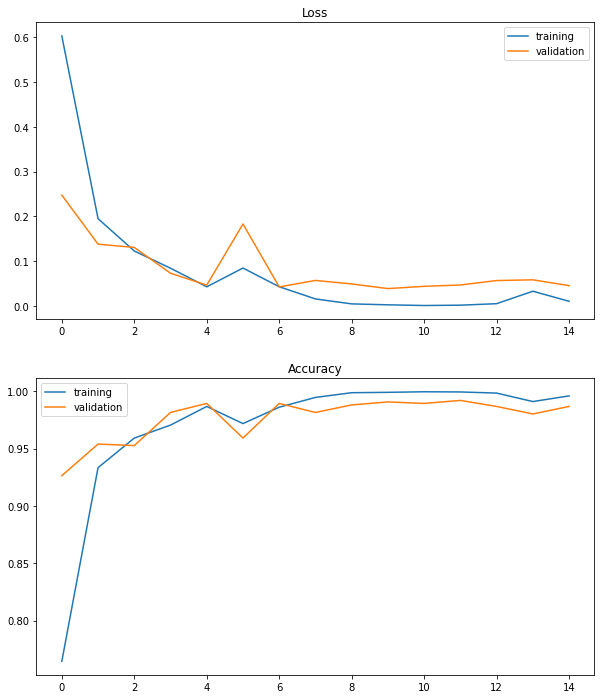

In [18]:
fig, (a1,a2) = plt.subplots(2,1, figsize=(10,12))

a1.plot(history1.history["loss"], label="training")
a1.plot(history1.history["val_loss"], label="validation")
a1.legend()
a1.set_title("Loss")

a2.plot(history1.history["accuracy"], label="training")
a2.plot(history1.history["val_accuracy"], label="validation")
a2.legend()
a2.set_title("Accuracy")

Looking at both graphs, we can see that the accuracy and loss curves start stabilizing at epoch 10. This provides direct evidence to why our model stopped at epoch 15, becuase the patience parameter for early stopping was set to 5.

## Manual Improvemnets & Hyperparameter Tuning
Hyperparameter are attributes or variables that we can set manually to improve the performance of the model. The main difference between hyperparameters and parameters are that hyperparameters are independent to the training data whereas the parameters are set according to the training data.
In most image classification problems, the following can be done:
* **Regularization**: This is not directly a hyperparameter but introduces important hyperparameters into our model. Regularization is the process of generalising the model so as to prevent overfitting. The most commonly used methods are l1, l2, dropout, max-norm, Monte Carlo dropout etc. For CNNs, dropout usually works well and can provide considerbale improvement when added just after the pooling layers. Regularization should be used if there is a significant difference in training accuracy and validation accuracy. The dropout layer has a hyperparameter that controls the percentage of dropout and is 0.5 (50%) by default. We can try out 0.2 as well as 0.7 for fine tuning.
* **Learning rate**: This is arguably the first hyperparameter that should tune. It controls how much we are adjusting the weights of our network with respect the loss gradient. The lower the value, the slower we travel along the downward slope.Typically, this is configured naively at random by the user. The best way to tune it is to try a learning rate 10 times higher as well as 10 times lower than the default. Whichever direction gives the better result should be explored further by further decreasing or increasing accordingly.
* **Epochs**: We did tune this using early stopping in our model.
* **Model Architecture**: This is the big one. Deep learning models when designed have infinte possibilities of what can be done. We can change the number of number of convolutional layers, no of dense layers, activation funtion, no of filters, filter size, pooling type, pooling value, stride, padding etc. To solve this, I prefer weilding the power of the Internet by looking up similar problems to the one at hand and copying those models first for my data. For example, I used the blueprint of a CNN taught in my Grad course for classifcation on the FashionMNIST data here. That was more complex, so I trimmed down a few layers. It is an iterative process and requires intuition and experience.  

We will not tune our model for the following two reasons:
* Colab has already crashed once due to RAM limitations and I prefer not risking it again. This is why I added the checkpoint callback.
* Our model has already given amazing results of close to 99% validation accuracy. Tuning with the aim of reaching 100% accuracy is unneccesary and might even harm our test accuracy.

## Final Steps
Penultimately, we calculate the accuracy of our model on our untouched test data.

In [19]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 19ms/step - loss: 0.0646 - accuracy: 0.9856


[0.06461290270090103, 0.9855642914772034]

We get 98.56% test accuracy, which is very close to the validation and training accuracy we obtained. This indicates that our model has generalised well. Finally, we save our model in `.h5` format so that it can be used in scripts or othe projects. 

In [20]:
#GConly
from google.colab import files

files.download("model1.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>